# Анализ и визуализация

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from mask_utils import compute_temporal_stability, compute_area, compute_iou
from vis_utils import overlay_mask_on_frame
from io_utils import load_video_frames

Обрабатываем вариант: baseline
Покадровые маски: baseline


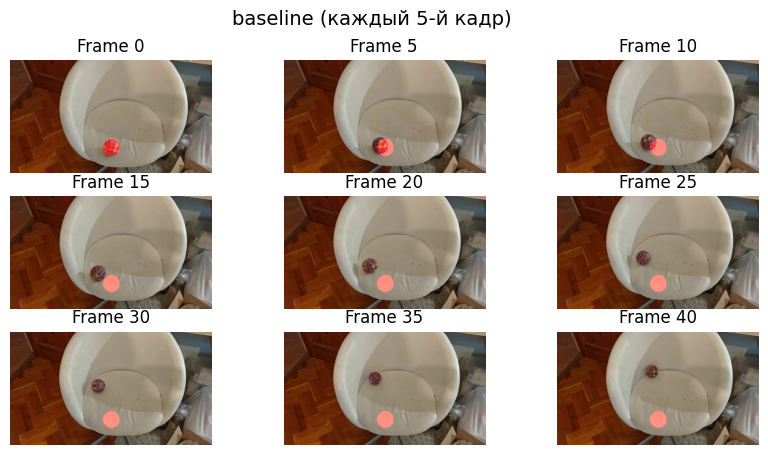

Сохранено видео: ../output\baseline\baseline_overlay.mp4
Обрабатываем вариант: forward
Покадровые маски: forward


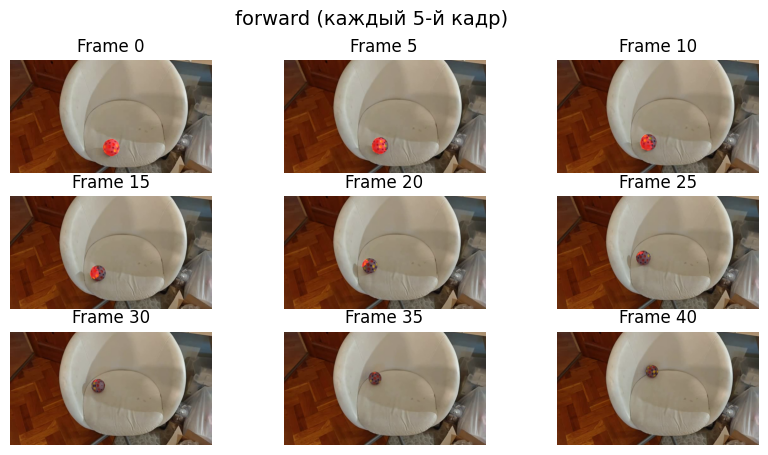

Сохранено видео: ../output\forward\forward_overlay.mp4
Обрабатываем вариант: forward_smooth
Покадровые маски: forward_smooth


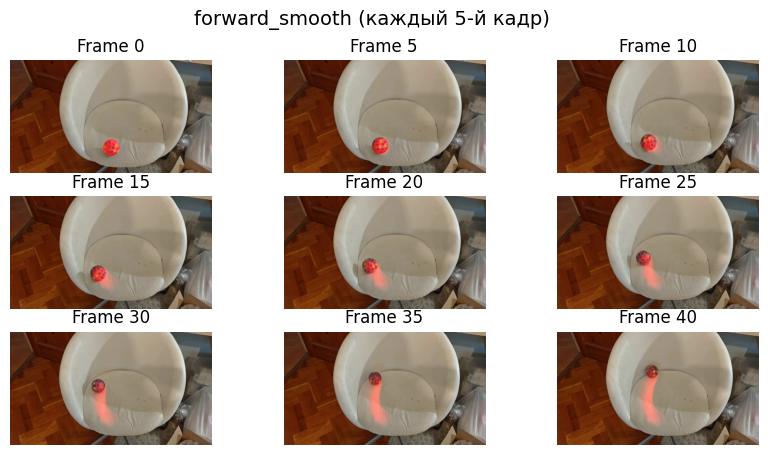

Сохранено видео: ../output\forward_smooth\forward_smooth_overlay.mp4
Обрабатываем вариант: forward_smooth_morph
Покадровые маски: forward_smooth_morph


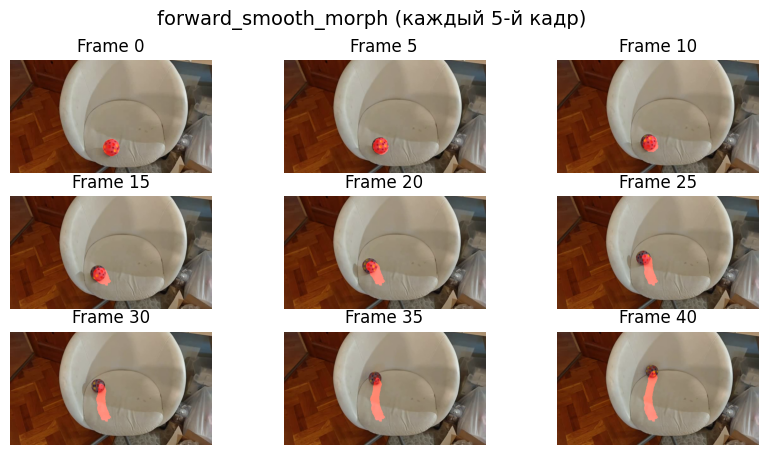

Сохранено видео: ../output\forward_smooth_morph\forward_smooth_morph_overlay.mp4
Обрабатываем вариант: bidirectional
Покадровые маски: bidirectional


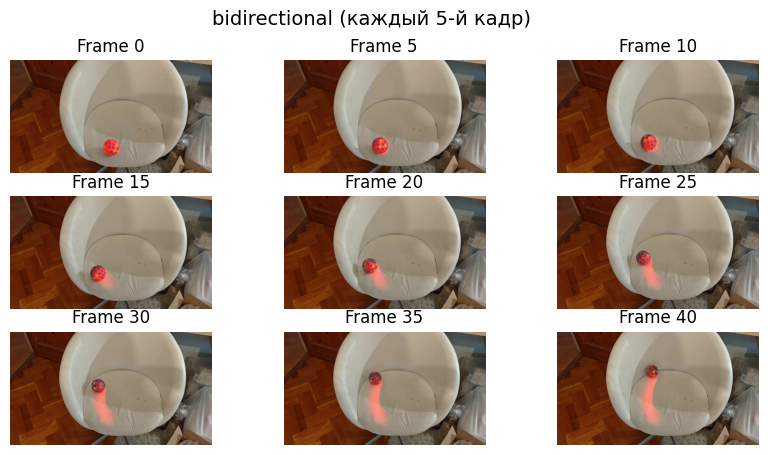

Сохранено видео: ../output\bidirectional\bidirectional_overlay.mp4


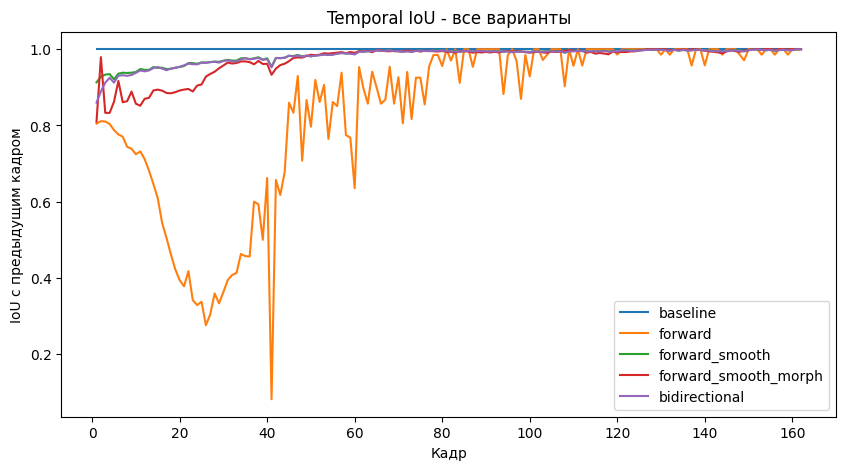

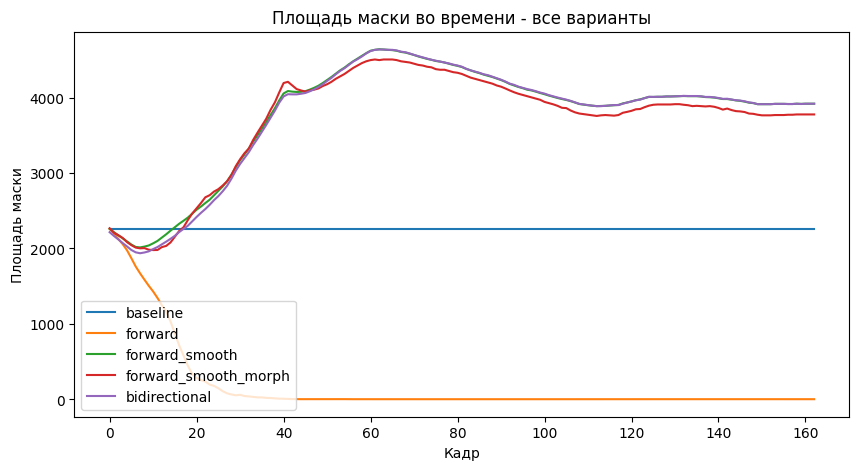

baseline: temporal stability = 0.0000
forward: temporal stability = 0.0003
forward_smooth: temporal stability = 0.0003
forward_smooth_morph: temporal stability = 0.0004
bidirectional: temporal stability = 0.0003


In [4]:
def load_masks_from_dir(dir_path):
    mask_files = sorted([f for f in os.listdir(dir_path) if f.endswith(".png")])
    masks = [cv2.imread(os.path.join(dir_path, f), cv2.IMREAD_GRAYSCALE)/255 for f in mask_files]
    masks = [m.astype(np.float16) for m in masks]
    return masks

variants = ["baseline", "forward", "forward_smooth", "forward_smooth_morph", "bidirectional"]
output_base = '../output'

frames = load_video_frames('../input_resized.mp4')

all_ious = {}
all_areas = {}
temporal_stabilities = {}

num_frames = len(frames)
step = 5
frames_to_show = list(range(0, num_frames, step))[:9]

cap = cv2.VideoCapture('../input_resized.mp4')
H, W = frames[0].shape[:2]
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

for variant in variants:
    print(f"Обрабатываем вариант: {variant}")
    dir_path = os.path.join(output_base, variant)
    masks = load_masks_from_dir(dir_path)
    
    ious = compute_iou(masks)
    areas = compute_area(masks)
    stability = compute_temporal_stability(masks)
    
    all_ious[variant] = ious
    all_areas[variant] = areas
    temporal_stabilities[variant] = stability

    print(f"Покадровые маски: {variant}")
    fig, axes = plt.subplots(3, len(frames_to_show) // 3, figsize=(10,5))
    for idx, frame_idx in enumerate(frames_to_show):
        axes[idx//3, idx%3].imshow(overlay_mask_on_frame(frames[frame_idx], masks[frame_idx]), cmap="gray")
        axes[idx//3, idx%3].axis("off")
        axes[idx//3, idx%3].set_title(f"Frame {frame_idx}")
    plt.suptitle(f"{variant} (каждый 5-й кадр)", fontsize=14)
    plt.show()

    out_path = os.path.join(dir_path, f"{variant}_overlay.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_path, fourcc, fps, (W, H))
    for i in range(len(frames)):
        overlay = overlay_mask_on_frame(frames[i], masks[i])
        overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
        out.write(overlay_bgr)
    out.release()
    print(f"Сохранено видео: {out_path}")

# Общий график IoU
plt.figure(figsize=(10,5))
for variant, ious in all_ious.items():
    plt.plot(range(1,len(ious)+1), ious, label=variant)
plt.xlabel("Кадр")
plt.ylabel("IoU с предыдущим кадром")
plt.title("Temporal IoU - все варианты")
plt.legend()
plt.show()

# Общий график площади
plt.figure(figsize=(10,5))
for variant, areas in all_areas.items():
    plt.plot(range(len(areas)), areas, label=variant)
plt.xlabel("Кадр")
plt.ylabel("Площадь маски")
plt.title("Площадь маски во времени - все варианты")
plt.legend()
plt.show()

for variant, stability in temporal_stabilities.items():
    print(f"{variant}: temporal stability = {stability:.4f}")